# imports

In [5]:
import os
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

In [2]:
ffmpg_path = os.path.abspath(r'C:\Users\pedro\OneDrive\Área de Trabalho\math_s\ffmpeg-20191101-53c21c2-win64-static\bin\ffmpeg.exe')
# os.environ['path'] += ';' + ffmpg_path
plt.rcParams['animation.ffmpeg_path'] = ffmpg_path

# Motivation

    Esses dias eu estava conversando com um amigo sobre um trabalho de conclusão. O trabalho era bem legal, a ideia era fazer um software que pudesse identificar as notas tocadas em uma gravação de violão. Na hora me peguei pensando em espectrogramas, wavelets, tranformadas, integrais coisa que a maioria dos estudantes de engenharia elétrica do quarto semestre, que estaria aprendendo agora os mistérios da matéria de DSP. Mas uma pedra no formato de bravata saída da boca do meu amigo voou na minha cabeça:
    
     - Ah, isso deve ser fácil... Esses audio em formato de mp3 não vêm meio que com as notas declaradas?

    Na hora me dei conta que dados em formato de chave valor, ou csvs, ou até listas encadeadas poderiam servir para guardar as notas de um instrumento...

In [4]:
data = [
    ('A', '00', '00', '01'),
    ('D', '00', '00', '01'),
    ('A', '00', '00', '01'),
    ('E', '00', '00', '01'),
    ('A', '00', '00', '01'),
]
df = pd.DataFrame(data, columns=['note', 'hour', 'minute', 'second'])
df

,note,hour,minute,second
0,A,00,00,01
1,D,00,00,01
2,A,00,00,01
3,E,00,00,01
4,A,00,00,01


In [8]:
json_string = json.dumps(
    [
        {'note': 'A', 'duration': 2},
        {'note': 'E', 'duration': 2},
        {'note': 'C', 'duration': 4},
        {'note': 'A', 'duration': 2},
        {'note': 'G', 'duration': 2}
    ], indent=4
)
print(json_string)

[
    {
        "note": "A",
        "duration": 2
    },
    {
        "note": "E",
        "duration": 2
    },
    {
        "note": "C",
        "duration": 4
    },
    {
        "note": "A",
        "duration": 2
    },
    {
        "note": "G",
        "duration": 2
    }
]


    Sim, isso parece ótimo e aposto que seria bem fácil de fazer isso virar música... Mas como que os microfones transformaria a vibração gerada pelos instrumentos propagada no ar nesse formato tão humano de música sem exatamente o que o tcc se propusia a fazer... Sim.
    Na real as notas são assim...

# sines

In [10]:
def cosine(time_vector, f):
    return np.cos(2 * np.pi * f * time_vector)

In [9]:
def plot_freq_points(frequency, time, x_offset=0, y_offset=0):
    period = 1 / frequency
    for i in np.arange(period, time + period, period):
        plt.plot(i + x_offset, y_offset, marker='o', color='r')

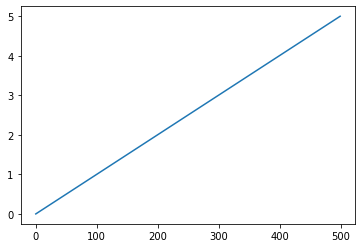

In [11]:
sampling_frequency = 100
time = 5
time_vector = np.linspace(0, time, int(sampling_frequency * time))
plt.plot(time_vector)
plt.show()

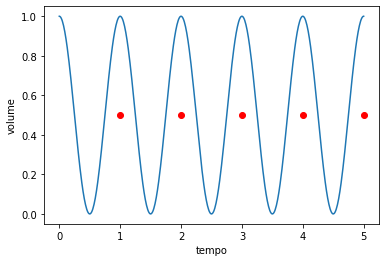

In [15]:
cos_1_vector = (cosine(time_vector, 1) + 1) / 2
plt.plot(time_vector, cos_1_vector)
plot_freq_points(1, time, y_offset=0.5)
plt.xlabel('tempo')
plt.ylabel('volume')
plt.show()

    Meu amigo se deu conta então que seria fácil fazer um software que seguisse mais ou menos o seguinte roteiro:
    
        1. Quantas amostras de amplitude (volume) formam (amostram) 1 segundo
        2. contar quantos pontas para cima (picos) e pontas para baixo (vales) tem em sequência
        3. verificar a frequência contando o número de picos acontecem em 1 segundo.

    Show... Isso deve ficar assim
    

In [20]:
going_up = cos_1_vector[0] > cos_1_vector[1]
going_down = cos_1_vector[0] < cos_1_vector[1]

wave_length_s = len(cos_1_vector) / sampling_frequency
print(f'Wave duration: {wave_length_s}s')
peeks, vales = 0, 0
sample_t_1 = cos_1_vector[0]
for i, sample_t in enumerate(cos_1_vector[1:]):
    if (sample_t > cos_1_vector[i]) and going_down:
        peeks += 1
    elif (cos_1_vector[i] > sample_t) and going_up:
        vales += 1
print(peeks, vales)


print((peeks + vales) / wave_length_s)
        
        
    

Wave duration: 5.0s
249 0
49.8


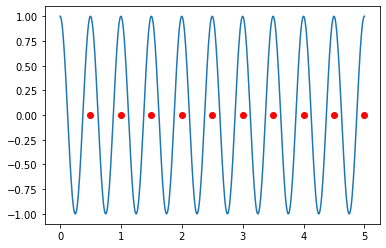

In [7]:
cos_2_vector = cosine(time_vector, 2)
plt.plot(time_vector, cos_2_vector)
plot_freq_points(2, time)
plt.show()

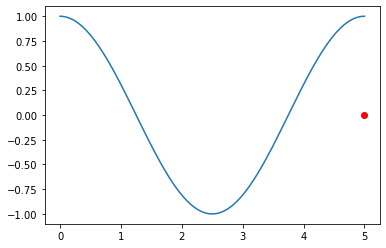

In [8]:
cos_02_vector = cosine(time_vector, 0.2)
plt.plot(time_vector, cos_02_vector)
plot_freq_points(0.2, time)
plt.show()

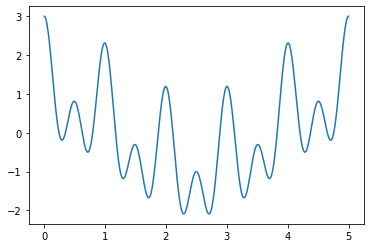

In [9]:
combined_cosine_vector = cos_02_vector + cos_2_vector + cos_1_vector
plt.plot(time_vector, combined_cosine_vector)
plt.show()

# And now?

In [10]:
def rotated_freq(time_vector, signal, f):
    k = -2j * np.pi
    return np.exp(k*f*time_vector) * signal

In [11]:
def polar(z):
    a= z.real
    b= z.imag
    r = math.hypot(a,b)
    theta = math.atan2(b,a)
    return theta, r

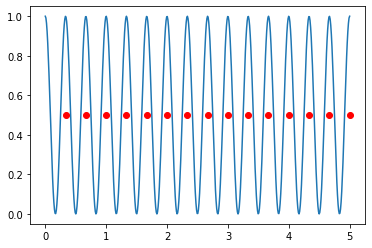

In [12]:
cos_3 = (cosine(time_vector, 3) + 1)/2
plt.plot(time_vector, cos_3)
plot_freq_points(3, time, y_offset=0.5)
plt.show()

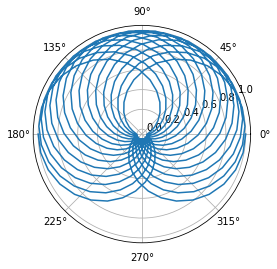

In [25]:
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

ax = plt.subplot(111, projection='polar')

line, = ax.plot([], [], lw=2)

def init():
    ax.plot([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    rf = rotated_freq(time_vector, cos_3, i * 0.1)
    rf_polar = np.array([polar(el) for el in rf])
    rf_theta = [el[0] for el in rf_polar] 
    rf_r = [el[1] for el in rf_polar]
    ax.clear()
    ax.plot(rf_theta, rf_r)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=30, interval=100, blit=True)

HTML(anim.to_html5_video())

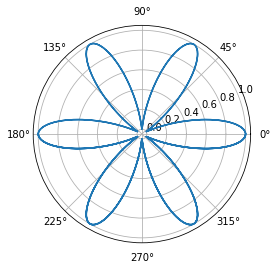

In [26]:
rf = rotated_freq(time_vector, cos_3, 0.5)
rf_polar = np.array([polar(el) for el in rf])
rf_theta = [el[0] for el in rf_polar] 
rf_r = [el[1] for el in rf_polar]
ax = plt.subplot(111, projection='polar')
ax.plot(rf_theta, rf_r)
plt.show()

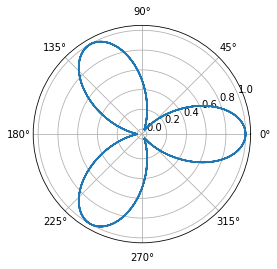

In [27]:
rf = rotated_freq(time_vector, cos_3, 1)
rf_polar = np.array([polar(el) for el in rf])
rf_theta = [el[0] for el in rf_polar] 
rf_r = [el[1] for el in rf_polar]
ax = plt.subplot(111, projection='polar')
ax.plot(rf_theta, rf_r)
plt.show()

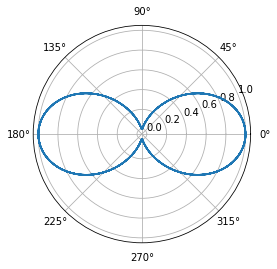

In [28]:
rf = rotated_freq(time_vector, cos_3, 1.5)
rf_polar = np.array([polar(el) for el in rf])
rf_theta = [el[0] for el in rf_polar] 
rf_r = [el[1] for el in rf_polar]
ax = plt.subplot(111, projection='polar')
ax.plot(rf_theta, rf_r)
plt.show()

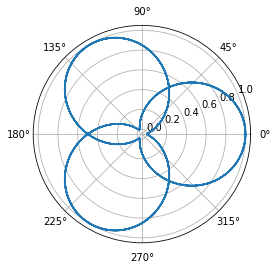

In [29]:
rf = rotated_freq(time_vector, cos_3, 2)
rf_polar = np.array([polar(el) for el in rf])
rf_theta = [el[0] for el in rf_polar] 
rf_r = [el[1] for el in rf_polar]
ax = plt.subplot(111, projection='polar')
ax.plot(rf_theta, rf_r)
plt.show()

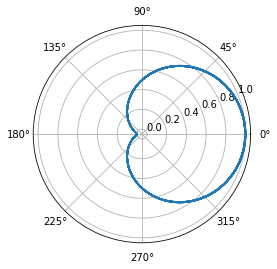

In [30]:
rf = rotated_freq(time_vector, cos_3, 3)
rf_polar = np.array([polar(el) for el in rf])
rf_theta = [el[0] for el in rf_polar] 
rf_r = [el[1] for el in rf_polar]
ax = plt.subplot(111, projection='polar')
ax.plot(rf_theta, rf_r)
plt.show()

In [31]:
np.mean(rf)

(0.2514999999999999+8.704148513061228e-17j)